<a href="https://colab.research.google.com/github/RubaNadeem/RubaNadeem/blob/main/Task_7_Time_Series_Breakdown_of_Retail_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()   # select train.csv, stores.csv, features.csv


Saving features.csv to features.csv
Saving stores.csv to stores.csv
Saving train.csv to train.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")

# Quick look at data
print("Train shape:", train.shape)
print(train.head())

print("\nStores shape:", stores.shape)
print(stores.head())

print("\nFeatures shape:", features.shape)
print(features.head())


Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Stores shape: (45, 3)
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemp

In [6]:
# Convert 'Date' column to datetime
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Check if conversion worked
print(train[['Date']].head())
print(features[['Date']].head())


        Date
0 2010-02-05
1 2010-02-12
2 2010-02-19
3 2010-02-26
4 2010-03-05
        Date
0 2010-02-05
1 2010-02-12
2 2010-02-19
3 2010-02-26
4 2010-03-05


In [7]:
# Add Year-Month column
train['YearMonth'] = train['Date'].dt.to_period('M')

# Aggregate weekly sales into monthly sales
monthly_sales = train.groupby(['YearMonth'])['Weekly_Sales'].sum().reset_index()

# Convert YearMonth back to datetime for plotting
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()

print(monthly_sales.head())


   YearMonth  Weekly_Sales
0 2010-02-01  1.903330e+08
1 2010-03-01  1.819198e+08
2 2010-04-01  2.314124e+08
3 2010-05-01  1.867109e+08
4 2010-06-01  1.922462e+08


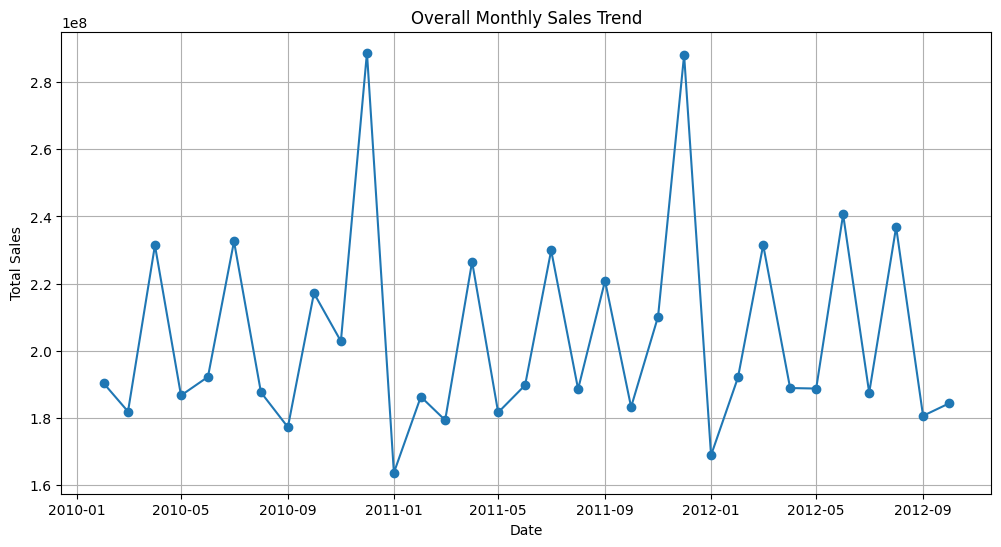

In [8]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Weekly_Sales'], marker='o')
plt.title("Overall Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


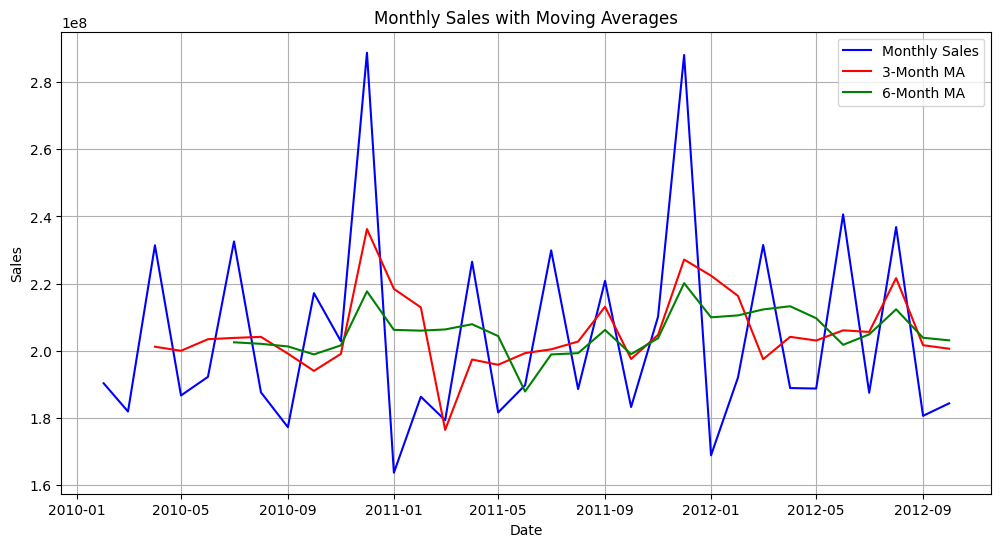

In [9]:
# 3-month and 6-month moving averages
monthly_sales['MA_3'] = monthly_sales['Weekly_Sales'].rolling(window=3).mean()
monthly_sales['MA_6'] = monthly_sales['Weekly_Sales'].rolling(window=6).mean()

# Plot with moving averages
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Weekly_Sales'], label="Monthly Sales", color="blue")
plt.plot(monthly_sales['YearMonth'], monthly_sales['MA_3'], label="3-Month MA", color="red")
plt.plot(monthly_sales['YearMonth'], monthly_sales['MA_6'], label="6-Month MA", color="green")

plt.title("Monthly Sales with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


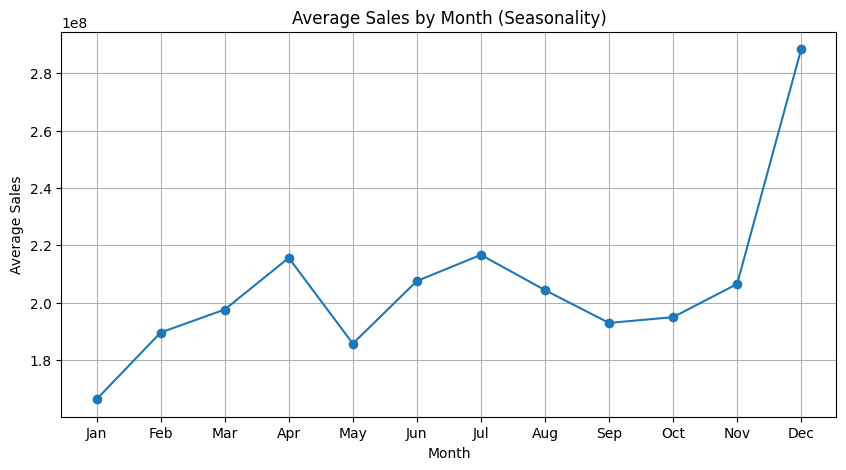

In [10]:
# Extract month number
monthly_sales['Month'] = monthly_sales['YearMonth'].dt.month

# Average sales by month (across all years)
seasonal_pattern = monthly_sales.groupby('Month')['Weekly_Sales'].mean().reset_index()

# Plot seasonal pattern
plt.figure(figsize=(10,5))
plt.plot(seasonal_pattern['Month'], seasonal_pattern['Weekly_Sales'], marker='o')
plt.title("Average Sales by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.xticks(range(1,13),
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True)
plt.show()


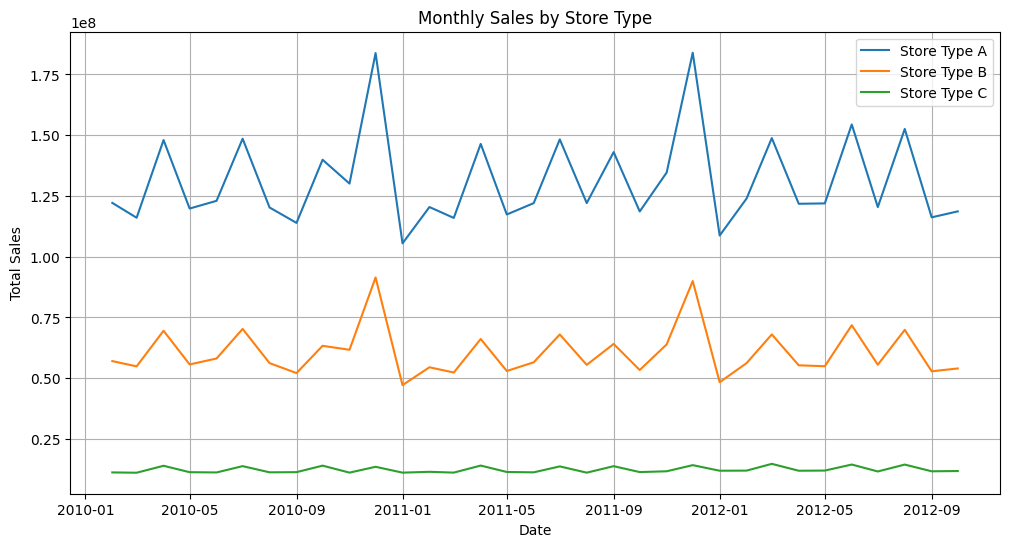

In [11]:
# Merge train with stores to get store type
train_merged = train.merge(stores, on="Store", how="left")

# Aggregate to monthly sales by store type
store_type_sales = (
    train_merged
    .groupby([pd.to_datetime(train_merged['Date']).dt.to_period('M'), 'Type'])['Weekly_Sales']
    .sum()
    .reset_index()
)

# Convert period to datetime
store_type_sales['YearMonth'] = store_type_sales['Date'].dt.to_timestamp()

# Plot sales trend by store type
plt.figure(figsize=(12,6))
for t in store_type_sales['Type'].unique():
    temp = store_type_sales[store_type_sales['Type'] == t]
    plt.plot(temp['YearMonth'], temp['Weekly_Sales'], label=f"Store Type {t}")

plt.title("Monthly Sales by Store Type")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.show()


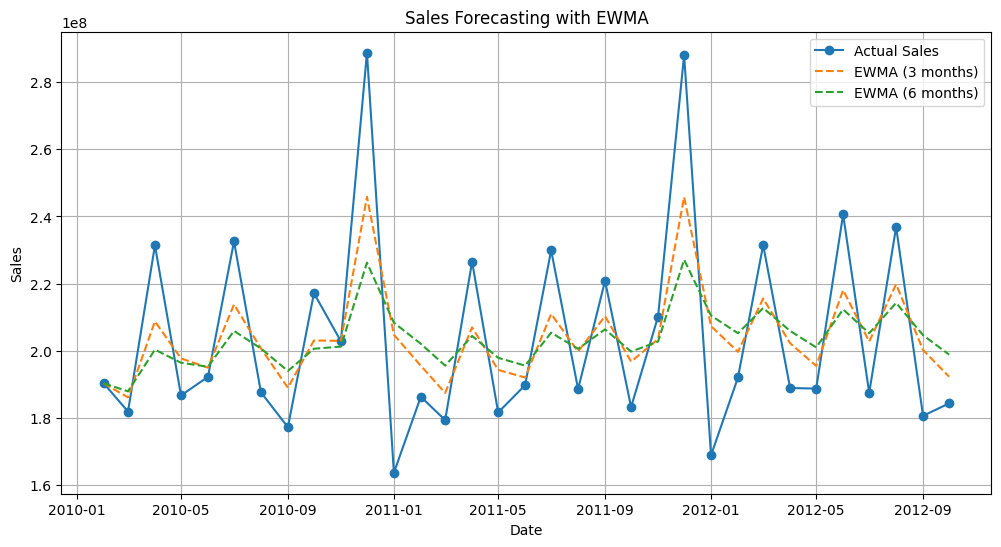

In [12]:
# Apply Exponential Weighted Moving Average (EWMA)
monthly_sales['EWMA_3'] = monthly_sales['Weekly_Sales'].ewm(span=3, adjust=False).mean()
monthly_sales['EWMA_6'] = monthly_sales['Weekly_Sales'].ewm(span=6, adjust=False).mean()

# Plot actual vs EWMA forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Weekly_Sales'], label='Actual Sales', marker='o')
plt.plot(monthly_sales['YearMonth'], monthly_sales['EWMA_3'], label='EWMA (3 months)', linestyle='--')
plt.plot(monthly_sales['YearMonth'], monthly_sales['EWMA_6'], label='EWMA (6 months)', linestyle='--')

plt.title("Sales Forecasting with EWMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()
